In [26]:
from os.path import join, expanduser
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from astra.torch.models import MLPRegressor
from joblib import delayed, Parallel

from tqdm.notebook import tqdm

import xarray as xr
from optree import tree_map
import matplotlib.pyplot as plt

# set numpy default dtype to float32

In [27]:
dec23 = xr.open_dataset('/home/patel_zeel/aqmsp/aqmsp_data/datasets/cpcb/ijcai24/data_dec23.nc')
dec23

<xarray.Dataset>
Dimensions:                    (time: 744, station: 46)
Coordinates:
  * time                       (time) datetime64[ns] 2023-12-01T00:30:00 ... ...
  * station                    (station) object 'Alipur_Delhi_DPCC' ... 'Wazi...
    lat                        (station) float64 ...
    lon                        (station) float64 ...
    elevation                  (station) float64 ...
    pop_1km                    (station) float64 ...
    pop_2km                    (station) float64 ...
    pop_3km                    (station) float64 ...
    pop_4km                    (station) float64 ...
    pop_5km                    (station) float64 ...
    pop_10km                   (station) float64 ...
    d_motorway                 (station) float64 ...
Data variables: (12/417)
    TSURF_K                    (time, station) float32 ...
    SNOWEW_M                   (time, station) float32 ...
    SNOWAGE_HR                 (time, station) float32 ...
    PRATE_MMpH                 (time, station) float32 ...
    CLOUD_OD                   (time, station) float32 ...
    U10_MpS                    (time, station) float32 ...
    ...                         ...
    UWIND_MpS_LAY0_lag_1       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_2       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_3       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_4       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_5       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_6       (time, station) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023264
    CTIME:          73659
    WDATE:          2023264
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [28]:
train_locs = np.load(join(f"/home/patel_zeel/aqmsp/aqmsp_data/datasets/cpcb/ijcai24/fold_0_train.npy"))
test_locs = np.load(join(f"/home/patel_zeel/aqmsp/aqmsp_data/datasets/cpcb/ijcai24/fold_0_test.npy"))
len(train_locs), len(test_locs)

(34, 12)

In [29]:
dec23['PM2.5'].min(dim="time").to_dataframe()

,lat,lon,elevation,pop_1km,pop_2km,pop_3km,pop_4km,pop_5km,pop_10km,d_motorway,PM2.5
station,,,,,,,,,,,
Alipur_Delhi_DPCC,28.815329,77.153010,232.723892,5191.0,24590.0,56670.0,103330.0,162318.0,1311725.0,0.099828,43.250000
Anand_Vihar_Delhi_DPCC,28.647622,77.315809,228.054230,112532.0,345187.0,928630.0,1585374.0,2558179.0,7269747.0,0.019716,54.500000
Arya_Nagar_Bahadurgarh_HSPCB,28.670100,76.925400,235.903046,3634.0,47417.0,109756.0,181711.0,224451.0,577259.0,0.095984,8.725000
Ashok_Vihar_Delhi_DPCC,28.695381,77.181665,239.118973,102389.0,484199.0,982964.0,1648546.0,2388044.0,7845002.0,0.113705,52.750000
Aya_Nagar_Delhi_IMD,28.470691,77.109936,296.356903,11294.0,70928.0,174717.0,266712.0,422490.0,1553858.0,0.034205,7.427500
Bawana_Delhi_DPCC,28.776200,77.051074,240.573120,9434.0,44755.0,108132.0,183934.0,309789.0,2100732.0,0.129472,52.000000
CRRI_Mathura_Road_Delhi_IMD,28.551201,77.273574,237.021194,96539.0,427379.0,838143.0,1183225.0,1592967.0,5094837.0,0.025881,28.795000
Dr._Karni_Singh_Shooting_Range_Delhi_DPCC,28.498571,77.264840,274.515350,7512.0,152860.0,300276.0,599808.0,933677.0,3462941.0,0.078968,47.000000
Dwarka_Sector_8_Delhi_DPCC_,28.571027,77.071901,238.335907,26610.0,131052.0,264859.0,450101.0,772939.0,3621461.0,0.051233,60.250000


In [30]:
# class CustomDataset(nn.Module):
#     def __init__(self, ds):
#         self.ds = ds
#         self.ts = ds.time.values
#         self.stations = ds.station.values
        
#     def __len__(self):
#         return len(self.ts) - 1
    
#     def __getitem__(self, idx):
#         sid = torch.randint(0, len(self.stations), ())
#         station = self.stations[sid]
#         curr_time = self.ts[idx+1]
#         prev_time = self.ts[idx]
#         station_pm25 = self.ds.sel(time=curr_time, station=station)["PM2.5"].values.reshape(1)
#         previous_pm25 = self.ds.sel(time=prev_time, station=station)["PM2.5"].values.reshape(1)
#         station_prev_ws = self.ds.sel(time=prev_time, station=station)["WS_MpS_3d"].values.reshape(1)
#         other_stations = list(self.stations)
#         other_stations.remove(station)
#         others_ds = self.ds.sel(time=prev_time, station=other_stations)
        
#         lat_diff = self.ds.sel(station=station)["lat"].item() - others_ds['lat'].values
#         lon_diff = self.ds.sel(station=station)["lon"].item() - others_ds['lon'].values
#         distances = np.sqrt(lat_diff**2 + lon_diff**2)
#         angles = np.arctan2(lat_diff, lon_diff)
#         wind_angles = np.arctan(others_ds["VWIND_MpS_3d"].values / (others_ds["UWIND_MpS_3d"].values + 1e-10))
#         speeds = others_ds["WS_MpS_3d"].values
#         cosine_similarity = np.cos(angles) * np.cos(wind_angles) * speeds
        
#         gen_features = np.array([self.ds.sel(station=station)["pop_5km"].item(), self.ds.sel(station=station)["d_motorway"].item()])
        
#         others_pm25 = others_ds["PM2.5"].values
    
#         return tree_map(lambda x: torch.tensor(x, dtype=torch.float32), (station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25))
    
# tmp_dataset = CustomDataset(dec23)
# tmp_dataloader = DataLoader(tmp_dataset, batch_size=3, shuffle=True)
# for station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25 in tmp_dataloader:
#     print("station_pm25", station_pm25.shape)
#     print("previous_pm25", previous_pm25.shape)
#     print("station_prev_ws", station_prev_ws.shape)
#     print("distances", distances.shape)
#     print("cosine_similarity", cosine_similarity.shape)
#     print("gen_features", gen_features.shape)
#     print("others_pm25", others_pm25.shape)
#     break

In [54]:
class Simulator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generated_pm_mlp = nn.Linear(1, 1)
        self.removed_pm_mlp = MLPRegressor(1, [8], 1)
        self.log_distance_weight_factor = nn.Parameter(torch.log(torch.tensor(1.0)))
        
    def forward(self, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25):
        pm_generated = F.softplus(self.generated_pm_mlp(gen_features[:, 2:3]))
        # decay_factor = F.softplus(self.removed_pm_mlp(station_prev_ws)) + 1
        # pm_retained = previous_pm25 * (decay_factor - 1) / decay_factor
        distance_weight_factor = torch.exp(self.log_distance_weight_factor)
        distance_weights = torch.exp(-(distances) / distance_weight_factor)
        weights = distance_weights * cosine_similarity
        weights = F.softmax(weights, dim=1)
        pm_received = torch.sum(weights * others_pm25, dim=1, keepdim=True)
        
        return pm_generated, pm_received, 0.0#pm_retained

In [32]:
train_ds = dec23.sel(station=train_locs)
min_pm = train_ds["PM2.5"].min().item()
max_pm = train_ds["PM2.5"].max().item()
train_ds["PM2.5"] = (train_ds["PM2.5"] - min_pm) / (max_pm - min_pm)

cache = {}
gen_fet = ["pop_5km", "d_motorway", "TEMP_K_LAY0", "PBL_WRF_M_lag_1"]
for fet in gen_fet:
    min_val = train_ds[fet].min().item()
    max_val = train_ds[fet].max().item()
    train_ds[fet] = (train_ds[fet] - min_val) / (max_val - min_val)
    cache[fet] = (min_val, max_val)

### Prepare dataset

In [48]:
def get_batch(ts):
    prev_time = train_ds.time.values[ts]
    curr_time = train_ds.time.values[ts+1]
    station_pm25_list = []
    previous_pm25_list = []
    station_prev_ws_list = []
    distances_list = []
    cosine_similarity_list = []
    gen_features_list = []
    others_pm25_list = []
    
    for station in train_locs:
        other_stations = list(train_locs)
        other_stations.remove(station)
        # print(curr_time, station)
        station_pm25 = train_ds.sel(time=curr_time, station=station)["PM2.5"].values.reshape(1, 1)
        previous_pm25 = train_ds.sel(time=prev_time, station=station)["PM2.5"].values.reshape(1, 1)
        station_prev_ws = train_ds.sel(time=prev_time, station=station)["WS_MpS_3d"].values.reshape(1, 1)
        others_ds = train_ds.sel(time=prev_time, station=other_stations)

        lat_diff = train_ds.sel(station=station)["lat"].item() - others_ds['lat'].values
        lon_diff = train_ds.sel(station=station)["lon"].item() - others_ds['lon'].values
        distances = np.sqrt(lat_diff**2 + lon_diff**2).reshape(1, -1)
        angles = np.arctan2(lat_diff, lon_diff)
        wind_angles = np.arctan(others_ds["VWIND_MpS_3d"].values / (others_ds["UWIND_MpS_3d"].values + 1e-10))
        speeds = others_ds["WS_MpS_3d"].values
        cosine_similarity = (np.cos(angles) * np.cos(wind_angles) * speeds).reshape(1, -1)

        gen_features = np.array([train_ds.sel(station=station)["pop_5km"].item(), train_ds.sel(station=station)["d_motorway"].item(), train_ds.sel(station=station, time=curr_time)["TEMP_K_LAY0"].item(), train_ds.sel(station=station, time=curr_time)["PBL_WRF_M_lag_1"].item()]).reshape(1, 4)

        others_pm25 = others_ds["PM2.5"].values.reshape(1, -1)
        
        station_pm25_list.append(station_pm25)
        previous_pm25_list.append(previous_pm25)
        station_prev_ws_list.append(station_prev_ws)
        distances_list.append(distances)
        cosine_similarity_list.append(cosine_similarity)
        gen_features_list.append(gen_features)
        others_pm25_list.append(others_pm25)

    station_pm25 = np.concatenate(station_pm25_list, axis=0)
    previous_pm25 = np.concatenate(previous_pm25_list, axis=0)
    station_prev_ws = np.concatenate(station_prev_ws_list, axis=0)
    distances = np.concatenate(distances_list, axis=0)
    cosine_similarity = np.concatenate(cosine_similarity_list, axis=0)
    gen_features = np.concatenate(gen_features_list, axis=0)
    others_pm25 = np.concatenate(others_pm25_list, axis=0)
    
    return station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25

batches = Parallel(n_jobs=48)(delayed(get_batch)(ts) for ts in tqdm(range(len(train_ds.time) - 1)))
len(batches)

  0%|          | 0/743 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [55]:
model = Simulator().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 20

epochs_losses = []
for epoch in range(epochs):
    randidx = np.random.permutation(len(batches))
    pbar = tqdm(batches)
    running_loss = 0.0
    for station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25 in pbar:
        optimizer.zero_grad()
        station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25 = tree_map(lambda x: torch.tensor(x, dtype=torch.float32).cuda(), (station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25))
        
        pm_gen, pm_rec, pm_ret = model(previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25)
        pm_pred = pm_gen + pm_rec + pm_ret
        loss = F.mse_loss(pm_pred, station_pm25)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"{loss.item():.4f}")
        running_loss += loss.item()
    epochs_losses.append(running_loss / len(batches))
    print(f"Epoch {epoch+1}/{epochs} Loss: {epochs_losses[-1]:.8f}")

  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 1/20 Loss: 0.01337157


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 2/20 Loss: 0.00532193


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 3/20 Loss: 0.00505398


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 4/20 Loss: 0.00497604


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 5/20 Loss: 0.00493101


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 6/20 Loss: 0.00480289


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 7/20 Loss: 0.00473781


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 8/20 Loss: 0.00471723


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 9/20 Loss: 0.00470503


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 10/20 Loss: 0.00469702


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 11/20 Loss: 0.00469145


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 12/20 Loss: 0.00468746


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 13/20 Loss: 0.00468453


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 14/20 Loss: 0.00468235


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 15/20 Loss: 0.00468073


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 16/20 Loss: 0.00467952


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 17/20 Loss: 0.00467863


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 18/20 Loss: 0.00467797


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 19/20 Loss: 0.00467749


  0%|          | 0/743 [00:00<?, ?it/s]

Epoch 20/20 Loss: 0.00467714


In [56]:
test_ds = dec23.sel(station=test_locs)

test_ds["PM2.5"] = (test_ds["PM2.5"] - min_pm) / (max_pm - min_pm)

for fet in gen_fet:
    min_val, max_val = cache[fet]
    test_ds[fet] = (test_ds[fet] - min_val) / (max_val - min_val)


other_stations = train_locs
preds = []
true_vals = []
def get_batch(ts):
    prev_time = test_ds.time.values[ts]
    curr_time = test_ds.time.values[ts+1]
    station_pm25_list = []
    previous_pm25_list = []
    station_prev_ws_list = []
    distances_list = []
    cosine_similarity_list = []
    gen_features_list = []
    others_pm25_list = []
    
    for station in test_locs:
        # print(curr_time, station)
        station_pm25 = test_ds.sel(time=curr_time, station=station)["PM2.5"].values.reshape(1, 1)
        previous_pm25 = test_ds.sel(time=prev_time, station=station)["PM2.5"].values.reshape(1, 1)
        station_prev_ws = test_ds.sel(time=prev_time, station=station)["WS_MpS_3d"].values.reshape(1, 1)
        others_ds = train_ds.sel(time=prev_time)

        lat_diff = test_ds.sel(station=station)["lat"].item() - others_ds['lat'].values
        lon_diff = test_ds.sel(station=station)["lon"].item() - others_ds['lon'].values
        distances = np.sqrt(lat_diff**2 + lon_diff**2).reshape(1, -1)
        angles = np.arctan2(lat_diff, lon_diff)
        wind_angles = np.arctan(others_ds["VWIND_MpS_3d"].values / (others_ds["UWIND_MpS_3d"].values + 1e-10))
        speeds = others_ds["WS_MpS_3d"].values
        cosine_similarity = (np.cos(angles) * np.cos(wind_angles) * speeds).reshape(1, -1)

        gen_features = np.array([test_ds.sel(station=station)["pop_5km"].item(), test_ds.sel(station=station)["d_motorway"].item(), test_ds.sel(station=station, time=curr_time)["TEMP_K_LAY0"].item(), test_ds.sel(station=station, time=curr_time)["PBL_WRF_M_lag_1"].item()]).reshape(1, 4)

        others_pm25 = others_ds["PM2.5"].values.reshape(1, -1)

        station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25 = tree_map(lambda x: torch.tensor(x, dtype=torch.float32), (station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25))
        
        station_pm25_list.append(station_pm25)
        previous_pm25_list.append(previous_pm25)
        station_prev_ws_list.append(station_prev_ws)
        distances_list.append(distances)
        cosine_similarity_list.append(cosine_similarity)
        gen_features_list.append(gen_features)
        others_pm25_list.append(others_pm25)

    station_pm25 = np.concatenate(station_pm25_list, axis=0)
    previous_pm25 = np.concatenate(previous_pm25_list, axis=0)
    station_prev_ws = np.concatenate(station_prev_ws_list, axis=0)
    distances = np.concatenate(distances_list, axis=0)
    cosine_similarity = np.concatenate(cosine_similarity_list, axis=0)
    gen_features = np.concatenate(gen_features_list, axis=0)
    others_pm25 = np.concatenate(others_pm25_list, axis=0)
    
    return station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25

test_batches = Parallel(n_jobs=48)(delayed(get_batch)(ts) for ts in tqdm(range(len(test_ds.time) - 1)))

  0%|          | 0/743 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
model.eval()
preds = []
gt = []
for station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25 in tqdm(test_batches):
    with torch.no_grad():
        station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25 = tree_map(lambda x: torch.tensor(x, dtype=torch.float32).cuda(), (station_pm25, previous_pm25, station_prev_ws, distances, cosine_similarity, gen_features, others_pm25))
        
        pm_gen, pm_rec, pm_ret = model(previous_pm25.cuda(), station_prev_ws.cuda(), distances.cuda(), cosine_similarity.cuda(), gen_features.cuda(), others_pm25.cuda())
    pm_pred = pm_gen + pm_rec + pm_ret
    preds.append(pm_pred.cpu().numpy() * (max_pm - min_pm) + min_pm)
    gt.append(station_pm25.cpu().numpy() * (max_pm - min_pm) + min_pm)
    
all_preds = np.stack(preds, axis=0)
all_gt = np.stack(gt, axis=0)
print(all_preds.shape, all_gt.shape)

  0%|          | 0/743 [00:00<?, ?it/s]

(743, 12, 1) (743, 12, 1)


61.88663


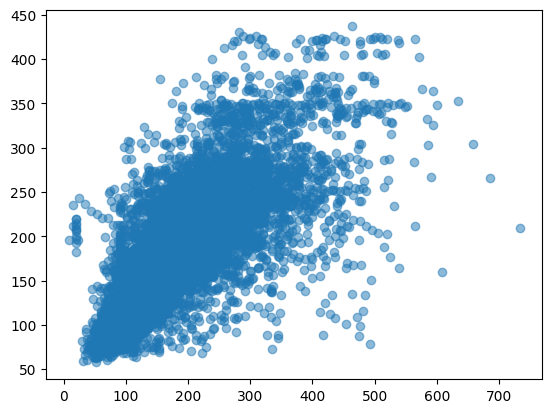

In [58]:
rmse = np.sqrt(np.mean((all_preds - all_gt) ** 2))
print(rmse)

plt.scatter(all_gt, all_preds, alpha=0.5)

In [59]:
pm_gen * (max_pm - min_pm) + min_pm

tensor([[7.4982],
        [7.5026],
        [7.4941],
        [7.5463],
        [7.4937],
        [7.4937],
        [7.4939],
        [7.4974],
        [7.4956],
        [7.4922],
        [7.4948],
        [7.4953]], device='cuda:0')

In [60]:
for name, param in model.named_parameters():
    print(name, param.data)

log_distance_weight_factor tensor(-1.8607, device='cuda:0')
generated_pm_mlp.weight tensor([[-3.9715]], device='cuda:0')
generated_pm_mlp.bias tensor([-7.2244], device='cuda:0')
removed_pm_mlp.featurizer.input_layer.weight tensor([[-0.4725],
        [ 0.8032],
        [-0.0511],
        [ 0.1056],
        [ 0.3410],
        [ 0.4853],
        [ 0.4234],
        [ 0.8602]], device='cuda:0')
removed_pm_mlp.featurizer.input_layer.bias tensor([-0.5211,  0.6033, -0.4916,  0.6359,  0.1285,  0.4992, -0.6158,  0.6550],
       device='cuda:0')
removed_pm_mlp.regressor.weight tensor([[-0.2816,  0.0538, -0.2612,  0.1508, -0.0310,  0.3261, -0.0049, -0.3219]],
       device='cuda:0')
removed_pm_mlp.regressor.bias tensor([0.3312], device='cuda:0')
